## Intro

The **Lecture slides** can be found [here](https://github.com/GDSL-UL/wma/raw/main/lectures/w04.pdf).

This **lab**'s notebook can be downloaded from [here](https://github.com/GDSL-UL/wma/blob/main/labs/w04_dataArch.ipynb).

In this lab, we will explore and familiarise with some of the most common data formats for web mapping: GeoJSON and Mbtiles. 

## GeoJSONs

To get familiar with the format, we will start by creating a GeoJSON file from scratch. Head over to the following website:

<https://geojson.io/>

In there, we will create together a small example to better understand the building blocks of this file format.

<img src="../labs_img/geojson.png" width="80%">

We will pay special attention to the following aspects:

-   Readability.
-   Coordinate system.
-   Ability to add non-spatial information attached to each record.
-   How to save it as a file.

<div class="alert alert-success">

**Excercise**:

Create a GeoJSON file for the following data and save them to separate files:

1.  Your five favourite spots in Liverpool
2.  A polygon of what you consider to be the boundary of the neighbourhood where you live and the city centre of Liverpool. Name each.
3.  A route that captures one of your favourite walks around the Liverpool region

If you are comfortable, upload the files to Microsoft Teams to share them with peers.

</div>

### GeoJSON in Python

With the files from the exercise at hand, we will learn how to open them in a Python environment. Then, let's begin by importing the necessary libraries; `geojson` is used for handling GeoJSON files.


In [2]:
import geopandas as gpd

Now, place the geojson files you have created in the data folder used in these sessions. As always, the data folder should be stored in the directory where the notebook is running from. For this example, we will assume that the file is called `map.geojson`. We can read the file as:


In [3]:
liverpool = gpd.read_file("../data/map.geojson")
liverpool.head()

,geometry
0,POINT (-2.96320 53.40471)
1,POINT (-2.96206 53.40471)
2,POINT (-2.96513 53.40163)
3,"LINESTRING (-2.96510 53.40163, -2.96505 53.402..."
4,"POLYGON ((-2.97048 53.40888, -2.96968 53.40573..."


We can also plot and explore the content of the GeoDataFrame with `Folium`. Folium, which we will see more in detail later on, helps create interactive maps from data stored in `geopandas.GeoDataFrame`.


In [4]:
import folium 

liverpool_centroid = (53.41058,	-2.97794)
# Create a Folium map centered around this point
map = folium.Map(location=liverpool_centroid, zoom_start=13, tiles="CartoDB.DarkMatterNoLabels")

# Add the liverpool data to the map, this will plot each geometry in the GeoDataFrame
folium.GeoJson(liverpool).add_to(map)
map

Once read, the geojson behaves exactly like any GeoDataFrame we have seen so far. We can therefore operate on it and tap into the functionality from `pandas` and `geopandas`. For example, we can and reproject the layer to the to British National Grid.


In [5]:
liverpool_bng = liverpool.to_crs(crs = "EPSG: 27700")

When we inspected our geojson, we noted that the spatial data is stored in the following format `POINT (-2.977367 53.40753)`. This is called "well known text" (`wkt`) and is a representation that spatial databases like PostGIS use as well. Another way to store spatial data as text for storage or transfer, less (human) readable but more efficient is the "well known blurb" (`wkb`). We can use the `shapely` library to handle the WKT representation of the geometry and then convert it to WKB format.


In [6]:
from shapely import wkt
from shapely.geometry import Point
import shapely.wkb

# Load the WKT representation of the point
wkt_string = "POINT (-2.977367 53.40753)"

# Convert the WKT representation into a Shapely Point object
point = wkt.loads(wkt_string)

# Convert the Point object into WKB format
wkb_data = shapely.wkb.dumps(point)
wkb_data.hex()

'01010000005e8429caa5d107c0c7116bf129b44a40'

<div class="alert alert-success">
    
**Excercise**:
-   Read the `GeoJSON` created for your favorite walks in Liverpool and calculate their length

</div>

Once you are happy with the data as we will hypothetically need it, you can write it out to any other file format supported in `geopandas`. For
example, we can create a Geopackge file with the same information. For this, we can use the function `to_file`. See an example below:


In [6]:
# Write 'liverpool_bng' to a GeoPackage file
liverpool_bng.to_file("../data/liverpool_bng.gpkg", layer="liverpool_bng", driver="GPKG")

## Tilesets
In this section we will dive into the concept of tiles to understand why they have been so transformative in the world of web mapping. We have
already seen the usage of tilesets above with `folium` and with `contextily` (although within a static context). We will see that `folium`, integrates different tileset options already.

For this section, let's start by getting the building footprints from OpenStreetMap with `osmnx`


In [7]:
import osmnx as ox
tags = {"building": True} #OSM tags
buildings = ox.features_from_place("Liverpool, UK", tags = tags) 
buildings = buildings.reset_index()
 # sometimes building footprints are represented by Points, let's disregard them
buildings = buildings[(buildings.geometry.geom_type == 'Polygon') | (buildings.geometry.geom_type == 'MultiPolygon')]

<Axes: >

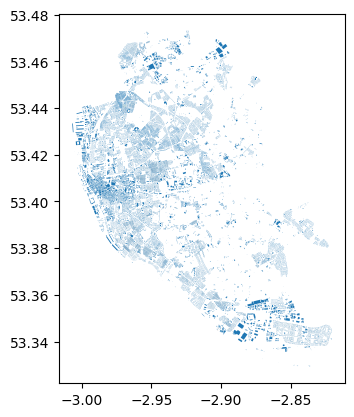

In [8]:
buildings.plot()

Let's save the GeoDataFrame a geojson and call it `buildings_liverpool.geojson`.


In [9]:
buildings[['osmid','geometry']].to_file('../data/buildings_liverpool.geojson',  driver='GeoJSON')

## Mapbox
[Register for a MapBox account here.](https://account.mapbox.com/auth/signup/?route-to=%22https%3A%2F%2Faccount.mapbox.com%2Faccess-tokens%2F%22)

Once your account is created and verified, Save both your username and public token as variables below:

In [10]:
mapbox_user = '' #Add your username here
mapbox_token = '' #Add your public token here (find this on the right hand side of the Mapbox console home page)

## Optional: Generating .mbtiles

**Note that this section is optional for those who are interested in trying out more advanced data formats. It is not required for this lab or the assignment** 
<div class="alert alert-block alert-warning">
IMPORTANT: This step cannot be ran on University Machines as the installation requires admin rights. Please skip to the next section - 'Mapbox Studio'
</div>

.mbtiles is a tile based data format, designed to assist the user in "making a scale-independent view of your data, so that at any level from the entire world to a single building, you can see the density and texture of the data rather than a simplification from dropping supposedly unimportant features or clustering or aggregating them. [[Source](https://github.com/mapbox/tippecanoe)]"

The following steps require the installation of `tippecanoe` on your machine. This cannot be installed directly onto Windows devices, and will require the installation of a local linux environment onto your device if you intend to use it.

### MAC or Linux Devices (Python)
In Python, the `togeojsontiles` package allows for us to convert our geojsons into .mbtiles files within our python code. Ensure you have installed **all** the [requirements](https://github.com/bartromgens/togeojsontiles) (ensuring that `togeojsontiles` is installed within the envs456 environment, not *base* and that 'tippecanoe' is properly set up from [here](https://github.com/mapbox/tippecanoe)), before trying the code below:

In [ ]:
from togeojsontiles import geojson_to_mbtiles

TIPPECANOE_DIR = '/usr/local/bin/'

# Convert GeoJSON to .mbtiles
geojson_to_mbtiles(
    filepaths=['../data/buildings_liverpool.geojson'],
    tippecanoe_dir=TIPPECANOE_DIR,
    mbtiles_file='../data/liverpool.mbtiles',
    maxzoom=14)

### Windows Devices (Linux Terminal)

Accessing `Tippecanoe` on windows machines is more complicated, **and cannot be done at all on University machines.** The above code is unlikely to work out of the box and in this case, the easiest way to access the functionality is through a Linux shell installed locally on your device. The steps to do this are outlined [here](https://gist.github.com/ryanbaumann/e5c7d76f6eeb8598e66c5785b677726e), and are briefly covered below:

1. Install a Linux Bash Shell (i.e. Ubuntu) - This can be done from the Microsoft Store.
2. Run the installed shell, completing set up by creating a username and password (remember these!)
3. Install Tippecanoe, using the commands listed in the above link.
4. Direct the bash terminal to your data directory. This requires a more extended filepath than python due to crossing over the different OS environments, (i.e. if your data filepath was C:\envs456\data, you would use the command: `$ cd ../../mnt/c/envs456/data`).
5. run the tippecanoe command: `$ tippecanoe -zg -o liverpool.mbtiles --drop-densest-as-needed buildings_liverpool.geojson` (for an explanation of the arguments we've used here see the command overview [here](https://github.com/mapbox/tippecanoe?tab=readme-ov-file#try-this-first))

This should build a .mbtile version of your 'buildings_liverpool' geojson directly into your data directory!

### Uploading Tiles
Once the .mbtile is created and saved in your directory, you can also try **uploading** it directly to Mapbox. This part of the code has not been tested so it should serve as guidance.

In [ ]:
import requests
import os

# Endpoint for Mapbox Tiling Service uploads
url = 'https://api.mapbox.com/uploads/v1/mapbox'

# Path to your .mbtiles file
mbtiles_file_path = "../data/liverpool.mbtiles'

# Prepare the headers
headers = {
    'Authorization': f'Bearer {mapbox_token}',
    'Content-Type': 'application/json'
}

# Prepare the data for the POST request
with open(mbtiles_file_path, 'rb') as file:
    files = {'file': file}
    response = requests.post(url, headers=headers, files=files)

# Check the response
if response.status_code == 200:
    print("Upload initiated successfully.")
    print(response.json())
else:
    print("Failed to initiate upload.")
    print(response.text)

\
***The optional steps end here***

## Mapbox Studio: 

After creating the `.mbtiles` file, you can upload it *manually* to Mapbox Studio (unless you managed to make the optional cell above work):

- Navigate to the Mapbox Studio Console.
- Start a New Style and chose a template (Monochrome, blank etc.)
  
<img src="../labs_img/mapboxstyles.png" width="80%">

- Upload the `liverpool.mbtiles` (if you created it) or the `buildings_liverpool.geojson`. Press the **+** symbol, `Custom Layer` or `Data Visualisation`, `Upload Data`, and choose your file
  
<img src="../labs_img/mapbox_upload.png" width="80%">

- Once uploaded, you should see your layer in the existing sources. Select this as the data to use for your layer and it will load in. If you skipped the optional step and are using a `.geoJSON` file, the Liverpool buildings may only render at a high level of zoom.

<img src="../labs_img/mapbox_select.png" width="80%">

- Style it according to your requirements: It should look like a nicer version of this:
  
<img src="../labs_img/mapbox_building_studio.png" width="80%">

Once you're happy with your styling, remember to publish your map so that we can reference it directly through the API.

### Visualizing the Tiles with `Folium`:

First, we need to get the `id` of your Mapbox style by copying its url:

<img src="../labs_img/mapbox_styleid.png" width="80%">

*url example*:  [mapbox://styles/gabrif/clrpby9lc00a501pecacz8b7h](mapbox://styles/gabrif/clrpby9lc00a501pecacz8b7h)

the `style_id` is the last section of the URL, in this case `clrpby9lc00a501pecacz8b7h`

Then, we can use `folium`, which we will more in detail later on, and use our tileset. Folium essentially allows us to create interactive maps, usually starting from data stored in a `GeoDataFrame`. While folium provides a series of built-in tilesets, here it is demonstrated how to employ one's own.

In [11]:
# Create a Folium map centered at a specific location, using a custom Mapbox styling
import folium

# save your style's ID
style_id = '' 

# Specify the API endpoint for your custom style
tiles = "https://api.mapbox.com/styles/v1/"+mapbox_user+"/"+style_id+"/tiles/256/{z}/{x}/{y}?access_token="+mapbox_token

# Create your map
map = folium.Map(location=[53.406872, -2.973286], zoom_start=14,
               tiles=tiles,
               attr='Mapbox')

# Display the map
map